In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from causalml.inference.tf import DragonNet

C:\Users\User\anaconda3\envs\MyChatBot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
df = pd.read_csv("C:/Users/User/Documents/GitHub/Health-impacts-of-air-pollution/MortData/NkaPollCardMort.csv", sep=';', header=0, index_col=0, parse_dates=True)


In [3]:
# Drop rows with missing mortality data
df_clean = df.dropna(subset=['death_count'])

In [4]:
# Define treatment: Days when PM2.5 > 40 & PM10 > 75
#df_clean['treatment'] = np.where((df_clean['pm2.5'] > 40) & (df_clean['pm10'] > 75), 1, 0)
df_clean['treatment'] = np.where((df_clean['pm2.5'] > 40), 1, 0)

C:\Users\User\AppData\Local\Temp\ipykernel_6564\3862700748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['treatment'] = np.where((df_clean['pm2.5'] > 40), 1, 0)


In [5]:
# Define features for propensity score matching
covariates = ['pm2.5', 'pm10', 'so2', 'no2', 'no', 'nox', 'o3', 'co', 'ws', 'wd', 'temp', 'relHum']

In [6]:
# Fit Propensity Score Model (Logistic Regression)
ps_model = LogisticRegression(solver='liblinear')
df_clean = df_clean.dropna(subset=covariates)  # Drop missing values in covariates
ps_model.fit(df_clean[covariates], df_clean['treatment'])

LogisticRegression(solver='liblinear')

In [7]:
# Generate Propensity Scores
df_clean['propensity_score'] = ps_model.predict_proba(df_clean[covariates])[:, 1]

In [8]:
# 1:1 Nearest Neighbor Matching
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
control_group = df_clean[df_clean['treatment'] == 0][['propensity_score']]
treated_group = df_clean[df_clean['treatment'] == 1][['propensity_score']]
nn.fit(control_group)
distances, indices = nn.kneighbors(treated_group)

In [9]:
# Create matched dataset
matched_control_indices = control_group.iloc[indices.flatten()].index
matched_data = pd.concat([df_clean.loc[matched_control_indices], df_clean[df_clean['treatment'] == 1]])

In [10]:
#  DragonNet (Deep Learning Causal Model)**
  
# Prepare data for DragonNet
X_dragon = matched_data[covariates].astype(np.float32)
treatment_dragon = matched_data['treatment'].astype(np.float32)
y_dragon = matched_data['death_count'].astype(np.float32)


In [11]:
# Standardize features
scaler = StandardScaler()
X_dragon_scaled = scaler.fit_transform(X_dragon)


In [12]:
# Train DragonNet
dragonnet = DragonNet()
dragonnet.fit(X_dragon_scaled, treatment_dragon, y_dragon)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - binary_classification_loss: 43.5693 - loss: 3484.6187 - regression_loss: 1698.0450 - track_epsilon: 0.1052 - treatment_accuracy: 0.4964 - val_binary_classification_loss: 26.8089 - val_loss: 2102.3569 - val_regression_loss: 860.9152 - val_track_epsilon: 0.1007 - val_treatment_accuracy: 0.7879 - learning_rate: 0.0010
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_classification_loss: 28.7297 - loss: 1349.1431 - regression_loss: 661.4230 - track_epsilon: 0.1014 - treatment_accuracy: 0.8901 - val_binary_classification_loss: 20.6282 - val_loss: 1091.7819 - val_regression_loss: 447.1097 - val_track_epsilon: 0.1039 - val_treatment_accuracy: 0.8081 - learning_rate: 0.0010
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_classification_loss: 19.1068 - loss: 692.1244 - regression_loss: 338.9092 - track_epsilon: 0.1049 - treatment_accuracy: 0.9267 - val_binary_classification_loss: 18.5712 - val_loss: 836.4679 - val_re

In [13]:
# Predict treatment effects
treatment_effects_dragon = dragonnet.predict(X_dragon_scaled)
#ate_dragon = treatment_effects_dragon[:, 2].mean()
#print(f"\n🔹 DragonNet Estimated ATE: {ate_dragon}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


In [14]:
#Here, you are calling .mean() directly on the entire treatment_effects array, which includes both columns. This can be misleading.
# To get the actual ATE as 𝜇1−𝜇0  , you need to subtract the two columns:
mu0 = treatment_effects_dragon[:, 0]
mu1 = treatment_effects_dragon[:, 1]
ite = mu1 - mu0  # Individual Treatment Effect for each sample
ate = ite.mean()
print("Average Treatment Effect (ATE):", ate)
# Otherwise, treatment_effects.mean() lumps together  𝜇1−𝜇0, which is not the difference.

Average Treatment Effect (ATE): 3.5788074


In [15]:
# 🔹 **Step 5: Visualizations**
# Plot mortality trends for treated vs. control groups
df_clean = df_clean.reset_index().rename(columns={'index': 'date'})
mortality_trend = df_clean.groupby(['date', 'treatment'])['death_count'].mean().unstack()

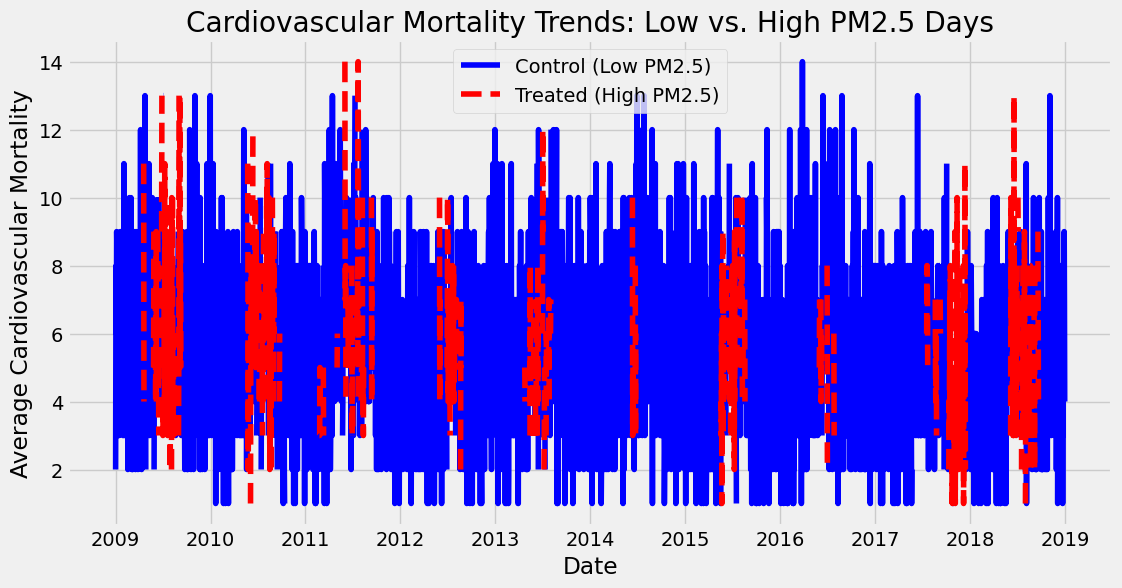

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(mortality_trend.index, mortality_trend[0], label="Control (Low PM2.5)", color='blue')
plt.plot(mortality_trend.index, mortality_trend[1], label="Treated (High PM2.5)", color='red', linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Average Cardiovascular Mortality")
plt.title("Cardiovascular Mortality Trends: Low vs. High PM2.5 Days")
plt.legend()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_6564\1241903341.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop=legend_properties)


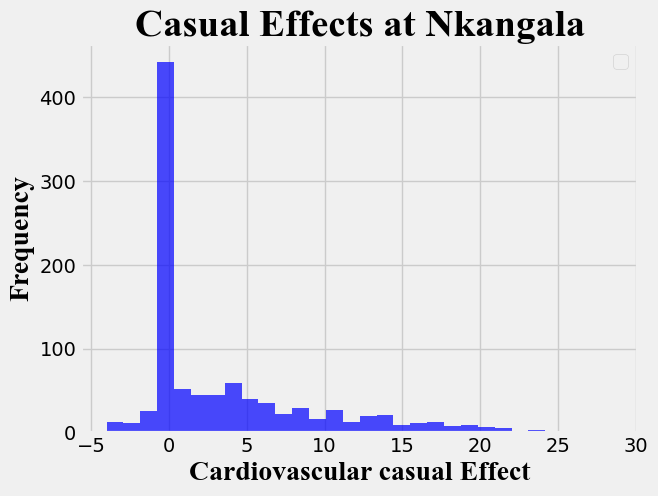

In [17]:
# Plot histogram of treatment effects
plt.hist(ite, bins=30, alpha=0.7, color='blue')
plt.title('Casual Effects at Nkangala', fontname="Times New Roman", size=28,fontweight="bold")
plt.xlabel('Cardiovascular casual Effect', fontname="Times New Roman", size=20,fontweight="bold")
plt.ylabel('Frequency', fontname="Times New Roman", size=20,fontweight="bold")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)
plt.show()